In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url='https://github.com/swoos91/COVID19_EDA/blob/master/pt/article.png?raw=true')

본 주제는 해당 기사에서 영감을 받았습니다.

강동구가 4월을 대비해 3월 동안 집중 방역을 추진했다는 내용으로,\
지난해 상반기 데이터를 분석하여 유동인구가 급격히 많아지는 지역을 선정해 방역 자원을 집중하겠다는 것이 골자입니다.

이에 착안하여,
생활인구가 지속적으로 증가하는 지역을 유형 별로 나눠 방역 관리에 도움이 되고자 준비해봤습니다.







> 출처: http://www.seoulilbo.com/news/articleView.html?idxno=410200

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import json
# from sklearn.preprocessing import MinMaxScaler

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
def ppl_map(df, ppl_diff_fnl):
    center = [37.541, 126.986] # 맵이 center 에 위치하고, zoom 레벨은 11로 시작하는 맵 m을 만듭니다. 
    m = folium.Map(location=center, zoom_start=10) # Choropleth 레이어를 만들고, 맵 m에 추가합니다. 
    folium.Choropleth( geo_data=df, data=ppl_diff_fnl, columns=('행정동코드', '총생활인구수'), key_on='feature.properties.행정동코드', fill_color='PuRd', legend_name='총생활인구수').add_to(m)
    
    # 맵 m을 출력합니다.

    return m

# 1. Preprocessing

### 1) 행정동 코드 전처리

In [4]:
loc_code = pd.read_csv('dataset/LOCAL_PEOPLE_DONG_201904/code.csv', encoding='euc-kr')
loc_code['시군구코드'] = loc_code['시군구코드'].astype(str)
loc_code['행정동코드'] = loc_code['행정동코드'].astype(str)
loc_code['행정동코드_'] = loc_code['시군구코드'] + loc_code['행정동코드']
loc_code = loc_code[loc_code['시도명'] == '서울특별시']
loc_code = loc_code[loc_code['행정동명'].isna() == False]
loc_code = loc_code[['행정동코드_', '시도명', '시군구명', '행정동명']]
loc_code['행정동명_'] = loc_code['시도명'] + ' ' + loc_code['시군구명'] + ' ' + loc_code['행정동명']
loc_code = loc_code[['시군구명', '행정동코드_', '행정동명_']]
loc_code = loc_code.drop_duplicates()
loc_code.isna().sum()

시군구명      0
행정동코드_    0
행정동명_     0
dtype: int64

In [5]:
loc_code['행정동코드_'] = loc_code['행정동코드_'].astype('int64')
loc_code['시군구코드'] = loc_code['행정동코드_'].astype(str).str.slice(0,5)

In [6]:
loc_code

,시군구명,행정동코드_,행정동명_,시군구코드
1789,동작구,11590530,서울특별시 동작구 상도제1동,11590
1791,동작구,11590540,서울특별시 동작구 상도제2동,11590
1792,동작구,11590550,서울특별시 동작구 상도제3동,11590
1793,동작구,11590560,서울특별시 동작구 상도제4동,11590
1794,동작구,11590570,서울특별시 동작구 본동,11590
...,...,...,...,...
48129,강동구,11740670,서울특별시 강동구 길제1동,11740
48131,강동구,11740680,서울특별시 강동구 길제2동,11740
89455,동대문구,11230535,서울특별시 동대문구 용두동,11230
93170,성동구,11200520,서울특별시 성동구 왕십리제2동,11200


### 2) 20년 03 월 / 04 월 생활인구 데이터 불러오기

#### - 20년 3월 데이터

In [7]:
ppl_2003 = pd.read_csv('dataset/LOCAL_PEOPLE_DONG_202003.csv')

# Fixing the index

col_names = ppl_2003.columns
ppl_2003 = ppl_2003.reset_index()
ppl_2003 = ppl_2003.iloc[:,:len(col_names)]
ppl_2003.columns = col_names
ppl_2003_ = ppl_2003.copy().round().astype('int64')

ppl_2003_.head()

,기준일ID,시간대구분,행정동코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20200301,0,11110515,14314,522,333,441,688,508,419,...,464,468,612,679,730,644,536,429,375,1108
1,20200301,0,11140520,5366,153,22,50,192,294,388,...,262,289,277,213,193,152,122,118,74,107
2,20200301,0,11140540,6986,98,41,85,228,266,395,...,261,256,321,256,264,217,232,238,199,374
3,20200301,0,11140550,6926,125,38,80,227,368,412,...,307,274,317,177,278,194,174,157,131,351
4,20200301,0,11140570,5446,95,32,136,342,306,246,...,309,212,175,113,176,172,196,200,96,375


In [8]:
# 결측치 확인

ppl_2003_.isna().sum()

기준일ID              0
시간대구분              0
행정동코드              0
총생활인구수             0
남자0세부터9세생활인구수      0
남자10세부터14세생활인구수    0
남자15세부터19세생활인구수    0
남자20세부터24세생활인구수    0
남자25세부터29세생활인구수    0
남자30세부터34세생활인구수    0
남자35세부터39세생활인구수    0
남자40세부터44세생활인구수    0
남자45세부터49세생활인구수    0
남자50세부터54세생활인구수    0
남자55세부터59세생활인구수    0
남자60세부터64세생활인구수    0
남자65세부터69세생활인구수    0
남자70세이상생활인구수       0
여자0세부터9세생활인구수      0
여자10세부터14세생활인구수    0
여자15세부터19세생활인구수    0
여자20세부터24세생활인구수    0
여자25세부터29세생활인구수    0
여자30세부터34세생활인구수    0
여자35세부터39세생활인구수    0
여자40세부터44세생활인구수    0
여자45세부터49세생활인구수    0
여자50세부터54세생활인구수    0
여자55세부터59세생활인구수    0
여자60세부터64세생활인구수    0
여자65세부터69세생활인구수    0
여자70세이상생활인구수       0
dtype: int64

#### - 20년 4월 데이터

In [9]:
ppl_2004 = pd.read_csv('dataset/행정동별 서울생활인구_20년 4월.csv', encoding='euc-kr')
ppl_2004_ = ppl_2004.copy().round().astype('int64')

# 3월을 제외한 4월 데이터만 추출

ppl_2004_ = ppl_2004_[ppl_2004_['기준일ID']>20200331]
ppl_2004_ = ppl_2004_.sort_values(by=['기준일ID'], ascending=True)
ppl_2004_.head()

,기준일ID,시간대구분,행정동코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
183167,20200401,23,11740700,33865,1181,596,958,908,1074,1203,...,1194,1121,1282,1289,1347,1385,1568,1421,1176,2626
176386,20200401,8,11110540,6230,79,60,122,417,230,381,...,181,252,269,224,192,194,230,192,171,325
176385,20200401,8,11110530,30394,417,185,237,623,1224,1692,...,1749,1799,1666,1374,1333,976,927,841,533,1572
176384,20200401,8,11110515,16544,531,338,441,711,775,695,...,566,630,743,729,677,658,645,421,378,1075
176383,20200401,7,11740700,33672,1192,601,926,911,1101,1264,...,1233,1165,1250,1343,1420,1383,1584,1374,1153,2551


In [10]:
# 결측치 확인

ppl_2004_.isna().sum()

기준일ID              0
시간대구분              0
행정동코드              0
총생활인구수             0
남자0세부터9세생활인구수      0
남자10세부터14세생활인구수    0
남자15세부터19세생활인구수    0
남자20세부터24세생활인구수    0
남자25세부터29세생활인구수    0
남자30세부터34세생활인구수    0
남자35세부터39세생활인구수    0
남자40세부터44세생활인구수    0
남자45세부터49세생활인구수    0
남자50세부터54세생활인구수    0
남자55세부터59세생활인구수    0
남자60세부터64세생활인구수    0
남자65세부터69세생활인구수    0
남자70세이상생활인구수       0
여자0세부터9세생활인구수      0
여자10세부터14세생활인구수    0
여자15세부터19세생활인구수    0
여자20세부터24세생활인구수    0
여자25세부터29세생활인구수    0
여자30세부터34세생활인구수    0
여자35세부터39세생활인구수    0
여자40세부터44세생활인구수    0
여자45세부터49세생활인구수    0
여자50세부터54세생활인구수    0
여자55세부터59세생활인구수    0
여자60세부터64세생활인구수    0
여자65세부터69세생활인구수    0
여자70세이상생활인구수       0
dtype: int64

#### - 20년 03 월/ 04 월 data concat

In [11]:
ppl = pd.concat([ppl_2003_, ppl_2004_])
ppl = ppl.sort_values(by=['기준일ID', '시간대구분'])
ppl['시군구코드'] = ppl['행정동코드'].astype(str).str.slice(0,5)
ppl['행정동코드_'] = ppl['행정동코드'].astype(str).str.slice(5,)

### 3) 20년 3월 대비 4월 1주차 토요일, 오후 6시 ~ 9시 사이에 생활인구가 증가하는 행정동 코드 추출
- 각 구 별 생활인구 증가율 상위 20%에 해당하는 행정동 코드 추출( dict 형태로 보관 )

In [12]:
gu = loc_code['시군구코드'].unique()
gu_dict = {}
for code in gu:
    mar = ppl[(ppl['시군구코드']==str(code)) & (ppl['기준일ID']==20200307) & (ppl['시간대구분'].isin([18,19,20,21]))]
    mar = mar.groupby('행정동코드').sum()
    apr = ppl[(ppl['시군구코드']==str(code)) & (ppl['기준일ID']==20200411) & (ppl['시간대구분'].isin([18,19,20,21]))]
    apr = apr.groupby('행정동코드').sum()
    ppl_diff = ((apr['총생활인구수'] - mar['총생활인구수'])/mar['총생활인구수']).sort_values(ascending = False)
    ppl_diff_MA = ppl_diff[:int(len(ppl_diff)*.2)]
    gu_dict[loc_code[loc_code['시군구코드']==str(code)]['시군구명'].unique()[0]] = ppl_diff_MA.index.values

In [13]:
gu_dict

{'동작구': array([11590651, 11590550, 11590560], dtype=int64),
 '관악구': array([11620585, 11620735, 11620595, 11620605], dtype=int64),
 '서초구': array([11650570, 11650531, 11650581], dtype=int64),
 '성북구': array([11290640, 11290580, 11290600, 11290770], dtype=int64),
 '종로구': array([11110615, 11110540, 11110630], dtype=int64),
 '강남구': array([11680750, 11680600, 11680630, 11680610], dtype=int64),
 '노원구': array([11350720, 11350621, 11350619], dtype=int64),
 '은평구': array([11380570, 11380690, 11380551], dtype=int64),
 '도봉구': array([11320521, 11320690], dtype=int64),
 '영등포구': array([11560700, 11560535, 11560540], dtype=int64),
 '중구': array([11140605, 11140520, 11140540], dtype=int64),
 '용산구': array([11170530, 11170580, 11170640], dtype=int64),
 '구로구': array([11530760, 11530550, 11530595], dtype=int64),
 '금천구': array([11545620, 11545510], dtype=int64),
 '성동구': array([11200550, 11200620, 11200650], dtype=int64),
 '서대문구': array([11410585, 11410615], dtype=int64),
 '마포구': array([11440660, 11440680, 1144

### 4) 각 행정동의 상권 별 주 매출 서비스 분야 파악

- 올해 동월 상권 매출 데이터를 이용하여 각 행정동의 주 매출 서비스 분야를 알아보는 것이 합리적이겠으나,\
현재는 해당 데이터에 접근할 수 없어 부득이 작년 2분기 상권 매출 데이터를 이용했습니다.\
작년 데이터를 이용하여 당월 주 매출 서비스 분야를 추정하므로, 참고만 부탁드리겠습니다. 

In [14]:
# 상권 영역 확인

mkt = pd.read_csv('dataset/서울시 우리마을가게 상권분석서비스(상권영역).csv', encoding='euc-kr')
mkt = mkt[['상권_코드_명', '상권_구분_코드_명', '상권_코드','행정동_코드']]
mkt.columns = ['상권명', '상권구분', '상권코드','행정동코드']

# 상권 별 매출건수/점포수 정렬
csm = pd.read_csv('dataset/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2019.csv', encoding = 'euc-kr')
csm = csm[csm['기준_분기_코드']==2]
csm = csm[~csm['상권_코드'].str.contains('^re', regex=True, na=False)]
csm['상권_코드'] = csm['상권_코드'].astype('int64')

C:\Users\mb910\Anaconda3\envs\covid\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 2. EDA

### 1) 각 주의 주중 / 주말 분포 확인
- 3월과 4월의 1주차 비교

In [15]:
def fix_df(df):
    df.index = ['일','월','화','수','목','금','토']
    df.columns = ['시간대구분', '행정동코드', '총생활인구수', '남 0~9', '남 10~14',
           '남 15~19', '남 20~24', '남 25~29',
           '남 30~34', '남 35~39', '남 40~44',
           '남 45~49', '남 50~54', '남 55~59',
           '남 60~64', '남 65~69', '남 70이상', '여 0~9',
           '여 10~14', '여 15~19', '여 20~24',
           '여 25~29', '여 30~34', '여 35~39',
           '여 40~44', '여 45~49', '여 50~54',
           '여 55~59', '여 60~64', '여 65~69',
           '여 70이상']
    df = df.iloc[:,2:]
#     df = df.loc[['월','화','수','목','금','토','일'], : ]
    
    return df

In [16]:
def week_analyze(dong, Wed):
    
    # 해당 행정동에서 주차 별 오후 6시 ~ 9시 사이의 생활인구 추출
    ppl_ = ppl[( ppl['행정동코드'] == dong )\
                & ( ppl['시간대구분'].isin( list( range(18, 22) ) ) )\
                & ( ppl['기준일ID'].isin( list( range( Wed, Wed+7 ) ) ) )]
    _ppl_ = ppl_.groupby('기준일ID').sum()
    
    return _ppl_ 

In [17]:
gu_dict.keys()

dict_keys(['동작구', '관악구', '서초구', '성북구', '종로구', '강남구', '노원구', '은평구', '도봉구', '영등포구', '중구', '용산구', '구로구', '금천구', '성동구', '서대문구', '마포구', '양천구', '강서구', '광진구', '동대문구', '중랑구', '송파구', '강동구', '강북구'])

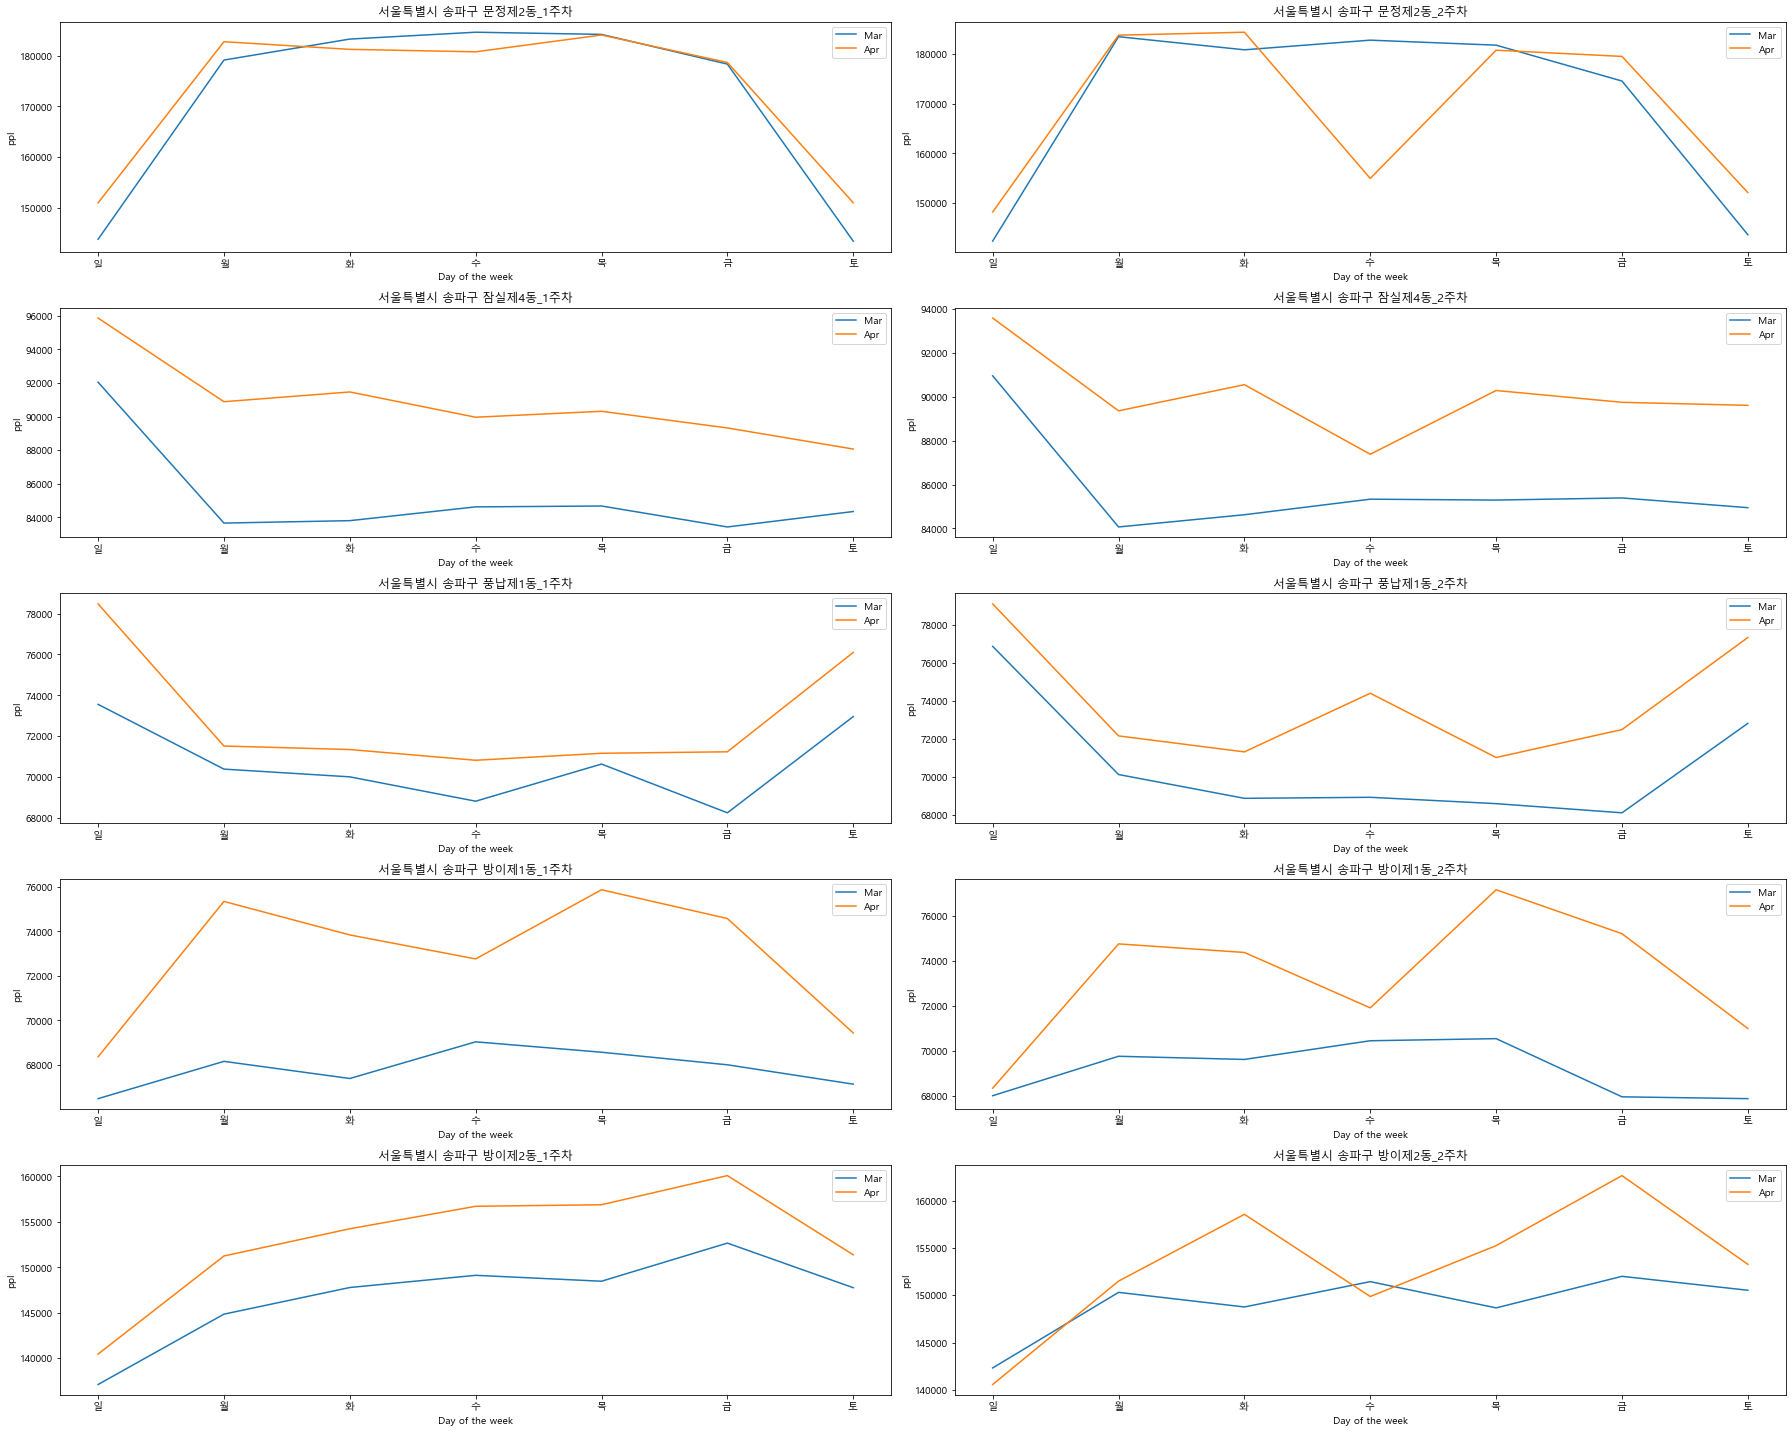

In [18]:
Gu = '송파구'
cpr_Week_Wed = [ 20200301, 20200405 ]

fig, ax = plt.subplots(len(gu_dict[Gu]),2, figsize=(25,20))

for i, gu_code in enumerate(gu_dict[Gu]):
    
    # 3월
    # 1주차

    ppl_mar_ = week_analyze(gu_code, cpr_Week_Wed[0])
    # index 및 column name 수정 + 컬럼 수 조정
    ppl_mar_1 = fix_df(ppl_mar_)

    # 2주차
    
    ppl_mar_ = week_analyze(gu_code, cpr_Week_Wed[0]+7)
    # index 및 column name 수정 + 컬럼 수 조정
    ppl_mar_2 = fix_df(ppl_mar_)

    # 4월
    # 1주차

    ppl_apr_ = week_analyze(gu_code, cpr_Week_Wed[1])
    # index 및 column name 수정 + 컬럼 수 조정
    ppl_apr_1 = fix_df(ppl_apr_)

    # 2주차
    
    ppl_apr_ = week_analyze(gu_code, cpr_Week_Wed[1]+7)
    # index 및 column name 수정 + 컬럼 수 조정
    ppl_apr_2 = fix_df(ppl_apr_)

    
    ax[i,0].plot( ppl_mar_1['총생활인구수'])
    ax[i,0].plot( ppl_apr_1['총생활인구수'])

    ax[i,0].title.set_text(loc_code[loc_code['행정동코드_'] == gu_code]['행정동명_'].values[0] + '_1주차')
    ax[i,0].legend(['Mar', 'Apr'], loc='upper right')
    ax[i,0].set_xlabel('Day of the week')
    ax[i,0].set_ylabel('ppl')
    
    ax[i,1].plot( ppl_mar_2['총생활인구수'])
    ax[i,1].plot( ppl_apr_2['총생활인구수'])

    ax[i,1].title.set_text(loc_code[loc_code['행정동코드_'] == gu_code]['행정동명_'].values[0] + '_2주차')
    ax[i,1].legend(['Mar', 'Apr'], loc='upper right')
    ax[i,1].set_xlabel('Day of the week')
    ax[i,1].set_ylabel('ppl')

plt.tight_layout()
plt.show()

구 별로 EDA를 진행하면서,\
다른 요일에 비해 금요일과 토요일 생활인구가 많고,\
3월 대비 4월에 생활인구가 증가하는 지역들을 다음과 같이 추려봤습니다.


- 관악구 낙성대동(샤로수길)

- 서초구 반포제2동(새빛섬), 반포제4동(남부터미널), 서초제4동(강남역 10번출구)

- 종로구 삼청동(토요일)

- 은평구 갈현제1동 (연신내역, 유흥지역)

- 영등포구 영등포동

- 서대문구 신촌동(금요일), 연희동(수,목)

- 마포구 서교동(홍대), 합정( 화(총선 전날), 금), 연남동

- 양천구 목제1동(금요일)

- 광진구 자양제4동(건대입구), 구의제3동(강변역)

- 송파 방이제2동


### 2) 행정동 별 0시 ~ 23시 생활인구 추이

- 3월 20일(금), 3월 21일(토), 3월 27일(금), 3월 28일(토), \
4월 3일(금), 4월 4일(토), 4월 10일(금), 4월 11일(토), \
4월 14일(화, 총선 전날), 4월 17일(금), 4월 18일(토)의 0시 ~ 23시 사이 생활인구 추이를 살펴봤습니다.

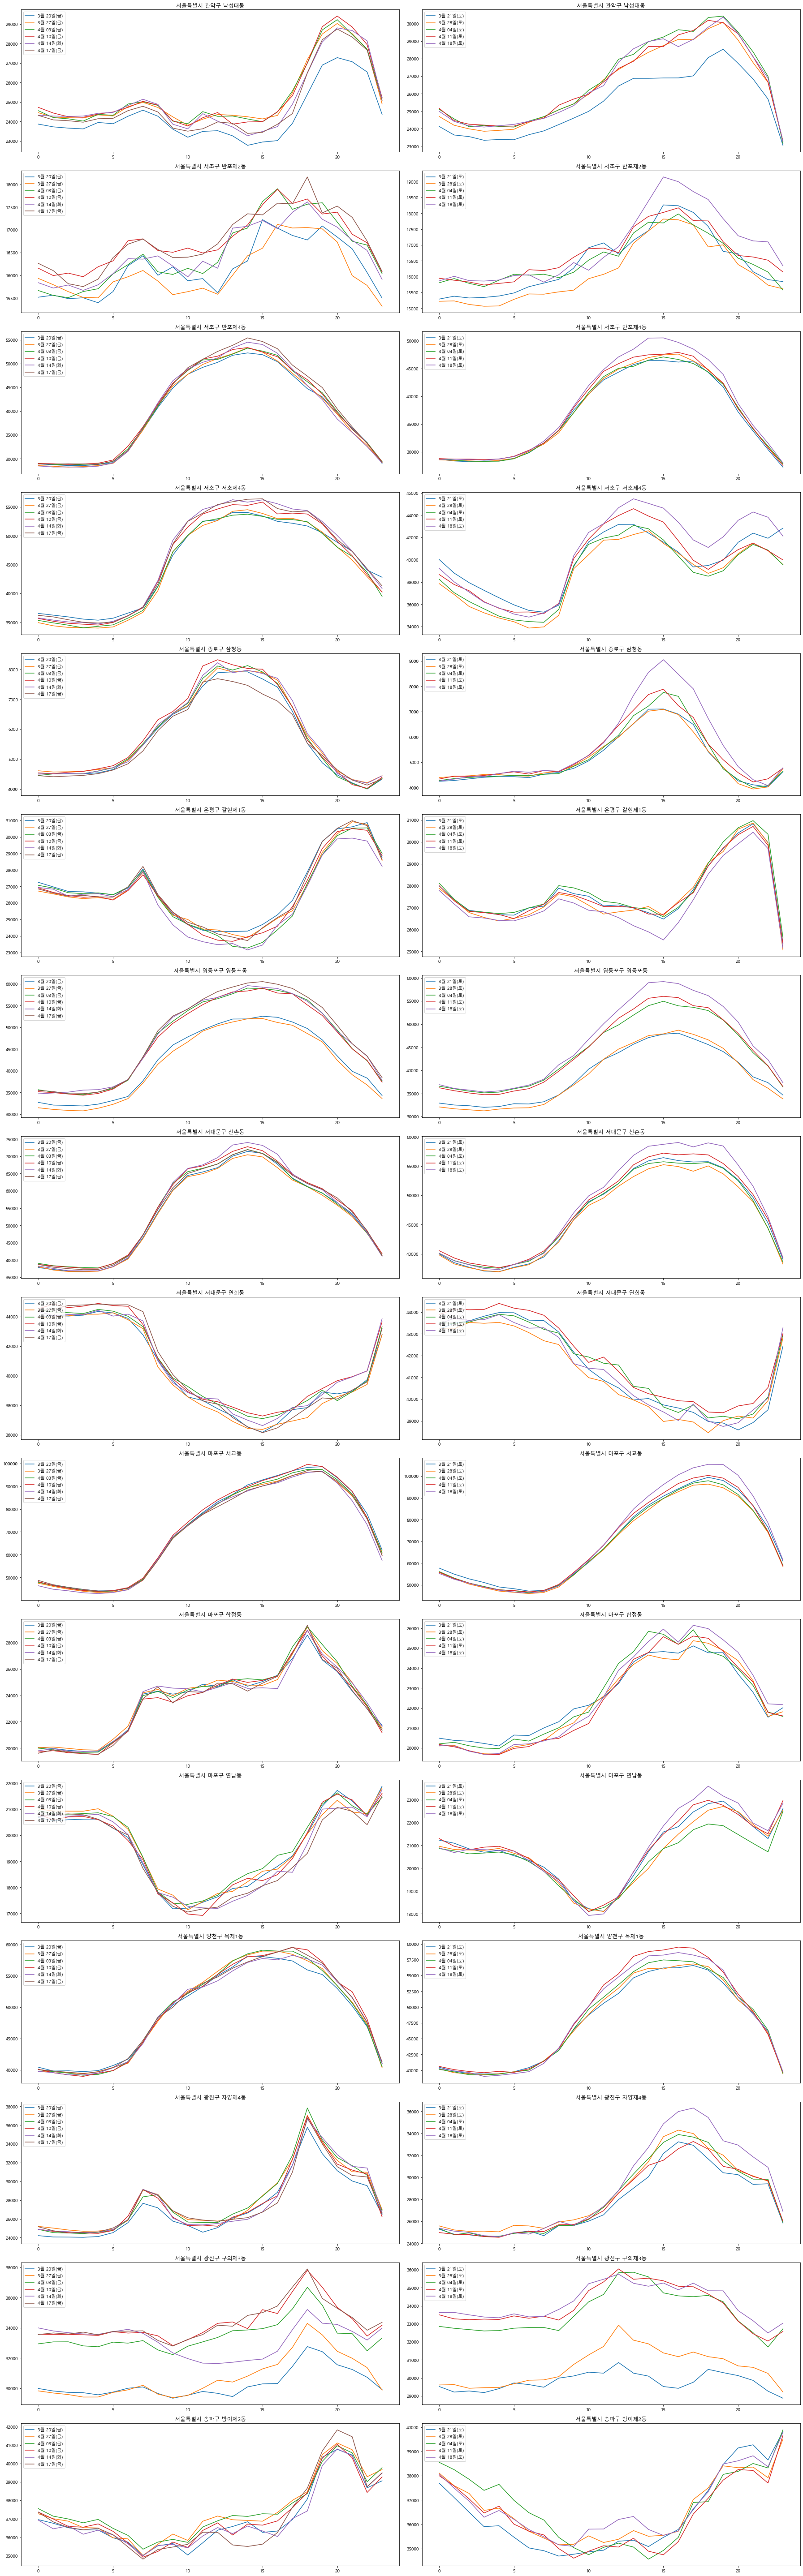

In [19]:
dong_code = [11620585, 11650570, 11650581, 11650531, 11110540, 11380551, 11560535, 11410585, 11410615, \
            11440660, 11440680, 11440710, 11470510, 11215847 , 11215870, 11710562]

fig, ax = plt.subplots(len(dong_code), 2, figsize=(25,80))
rc('font', family=font_name)

for i, dong in enumerate(dong_code):
    
    # 20년 03월 20일(금)
    ppl_Mar_20 = ppl[ ( ppl['기준일ID']==20200320 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    # 20년 03월 21일(토)
    ppl_Mar_21 = ppl[ ( ppl['기준일ID']==20200321 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    # 20년 03월 27일(금)
    ppl_Mar_27 = ppl[ ( ppl['기준일ID']==20200327 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    # 20년 03월 28일(토)
    ppl_Mar_28 = ppl[ ( ppl['기준일ID']==20200328 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    # 20년 04월 03일(금)
    ppl_Apr_03 = ppl[ ( ppl['기준일ID']==20200403 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    # 20년 04월 04일(토)
    ppl_Apr_04 = ppl[ ( ppl['기준일ID']==20200404 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    # 20년 04월 10일(금)
    ppl_Apr_10 = ppl[ ( ppl['기준일ID']==20200410 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    # 20년 04월 11일(토)
    ppl_Apr_11 = ppl[ ( ppl['기준일ID']==20200411 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    # 20년 04월 14일(화, 총선 전날)
    ppl_Apr_14 = ppl[ ( ppl['기준일ID']==20200414 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    # 20년 04월 17일(금)
    ppl_Apr_17 = ppl[ ( ppl['기준일ID']==20200417 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    # 20년 04월 18일(토)
    ppl_Apr_18 = ppl[ ( ppl['기준일ID']==20200418 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분')['총생활인구수']
    
    
    ax[i,0].plot( ppl_Mar_20 , label='3월 20일(금)')
    ax[i,1].plot( ppl_Mar_21 , label='3월 21일(토)')
    ax[i,0].plot( ppl_Mar_27 , label='3월 27일(금)')
    ax[i,1].plot( ppl_Mar_28 , label='3월 28일(토)')

    ax[i,0].plot( ppl_Apr_03 , label='4월 03일(금)')
    ax[i,1].plot( ppl_Apr_04 , label='4월 04일(토)')
    ax[i,0].plot( ppl_Apr_10 , label='4월 10일(금)')
    ax[i,1].plot( ppl_Apr_11 , label='4월 11일(토)')
    ax[i,0].plot( ppl_Apr_14 , label='4월 14일(화)')
    ax[i,0].plot( ppl_Apr_17 , label='4월 17일(금)')
    ax[i,1].plot( ppl_Apr_18 , label='4월 18일(토)' )
    ax[i,0].legend(loc='upper left')
    ax[i,1].legend(loc='upper left')
    ax[i,0].title.set_text(loc_code[loc_code['행정동코드_'] == dong]['행정동명_'].values[0])
    ax[i,1].title.set_text(loc_code[loc_code['행정동코드_'] == dong]['행정동명_'].values[0])

plt.tight_layout()
plt.show()

위의 그래프를 보면 크게 3가지 유형으로 나눠집니다.

- 화, 금, 토 모두 생활인구가 증가하는 지역:  반포제4동, 서초제4동, 영등포동
- 토요일에 생활인구가 지속적으로 증가하는 지역: 반포제2동, 삼청동, 신촌동, 서교동
- 지난 토요일에 갑자기 생활인구가 급증한 지역: 자양제4동
---
이를 바탕으로 유형 별 각 행정동의 특성을 살펴보겠습니다.


# 3. 유형 별 행정동 특성 분석

In [20]:
def ppl_trend(code, h1, h2):
    ppl_trend = ppl[ ( ppl['기준일ID']==20200418 ) & ( ppl['행정동코드']== code ) ].set_index('시간대구분').loc[list( range(h1, h2) ), :]
    ppl_trend_ = ppl_trend.groupby('행정동코드').sum().iloc[0,2:].sort_values(ascending=False).head(5)
    plt.bar(ppl_trend_.index, ppl_trend_)
    plt.tick_params(axis='x', rotation=90)

### 1) 화, 금, 토 모두 생활인구가 증가하는 지역

- 반포제4동 ( 토요일 13시 ~ 18시 사이 생활인구 )

In [21]:
Image(url = 'https://github.com/swoos91/COVID19_EDA/blob/master/pt/%EB%B0%98%ED%8F%AC%EC%A0%9C4%EB%8F%99.png?raw=true')

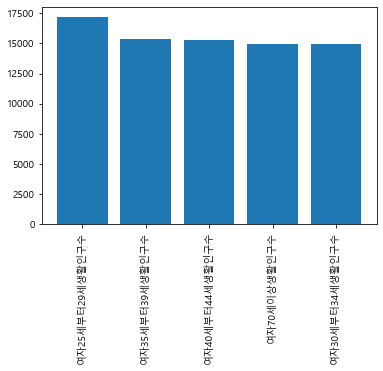

In [22]:
dong = 11650581
ppl_trend(dong, 13, 19)

In [23]:
main_service_tmp = csm[csm['상권_코드'].isin(mkt[mkt['행정동코드']== dong ]['상권코드'].values)].copy()
main_service_ = main_service_tmp.sort_values('토요일_매출_비율', ascending=False).head(20)['서비스_업종_코드_명'].value_counts().index[:5].values
print(loc_code[loc_code['행정동코드_'] == dong]['행정동명_'].values[0], ' : ',main_service_)

서울특별시 서초구 반포제4동  :  ['두발미용업' '패션용품' '노래방' '화장품' '화초·애완']


반포제4동은 토요일 기준으로 13시부터 18시에 인구가 몰립니다.\
주 연령층은 20 ~ 40대 여성으로, 작년 2분기 매출 데이터를 참고하면 ['두발미용업' '노래방' '화장품' '패션용품' '화초·애완'] 관련 서비스를 주로 이용합니다.

- 서초제4동 ( 11시 ~ 16시, 19시 ~ 22시 사이 생활인구 )

In [24]:
Image(url = 'https://github.com/swoos91/COVID19_EDA/blob/master/pt/%EC%84%9C%EC%B4%88%EC%A0%9C4%EB%8F%99.png?raw=true')

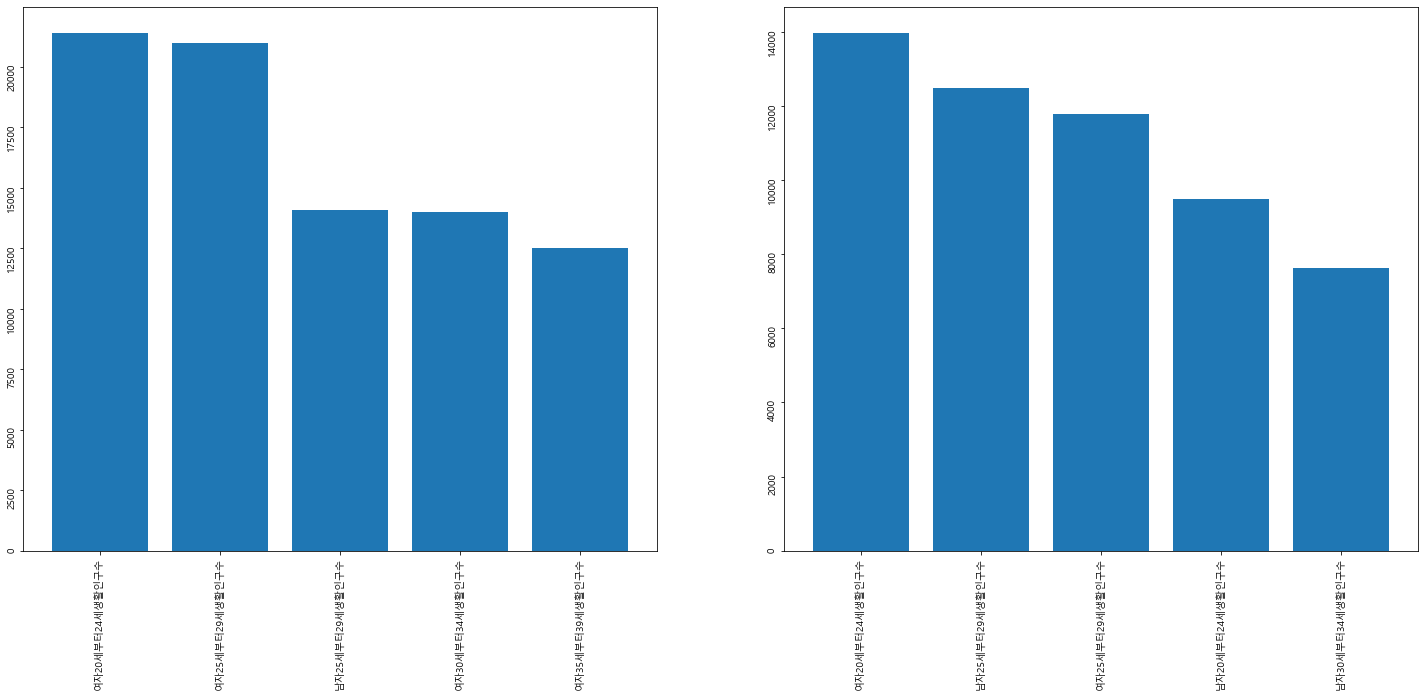

In [25]:
dong = 11650531

fig, ax = plt.subplots(1, 2, figsize=(25,10))
rc('font', family=font_name)

ppl_trend_ = ppl[ ( ppl['기준일ID']==20200418 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분').loc[list( range(11, 17) ), :]
ppl_trend_1 = ppl_trend_.groupby('행정동코드').sum().iloc[0,2:].sort_values(ascending=False).head(5)
ax[0].bar(ppl_trend_1.index, ppl_trend_1)
ax[0].tick_params(rotation=90)

ppl_trend_ = ppl[ ( ppl['기준일ID']==20200418 ) & ( ppl['행정동코드']== dong ) ].set_index('시간대구분').loc[list( range(19, 23) ), :]
ppl_trend_2 = ppl_trend_.groupby('행정동코드').sum().iloc[0,2:].sort_values(ascending=False).head(5)
ax[1].bar(ppl_trend_2.index, ppl_trend_2)
ax[1].tick_params(rotation=90)

In [26]:
main_service_tmp = csm[csm['상권_코드'].isin(mkt[mkt['행정동코드']== dong ]['상권코드'].values)].copy()
main_service_ = main_service_tmp.sort_values('토요일_매출_비율', ascending=False).head(20)['서비스_업종_코드_명'].value_counts().index[:5].values
print(loc_code[loc_code['행정동코드_'] == dong]['행정동명_'].values[0], ' : ',main_service_)

서울특별시 서초구 서초제4동  :  ['한의원' '두발미용업' '노래방' '패션용품' '의약·의료용품']


서초제4동은 토요일 기준으로 11시부터 16시, 19시 ~ 22시에 인구가 몰립니다.\
주 연령층은 20 ~ 30대로, 작년 2분기 매출 데이터를 참고하면 ['두발미용업' '한의원' '패션용품' '노래방' '슈퍼마켓'] 관련 서비스를 주로 이용합니다.

- 영등포동 ( 12시 ~ 18시 사이 생활인구 )

In [27]:
Image(url = 'https://github.com/swoos91/COVID19_EDA/blob/master/pt/%EC%98%81%EB%93%B1%ED%8F%AC%EB%8F%99.png?raw=true')

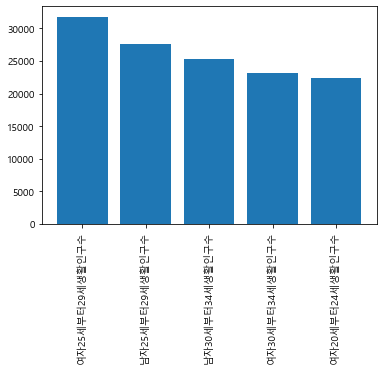

In [28]:
dong = 11560535
ppl_trend(dong, 12, 19)

In [29]:
main_service_tmp = csm[csm['상권_코드'].isin(mkt[mkt['행정동코드']== dong ]['상권코드'].values)].copy()
main_service_ = main_service_tmp.sort_values('토요일_매출_비율', ascending=False).head(20)['서비스_업종_코드_명'].value_counts().index[:5].values
print(loc_code[loc_code['행정동코드_'] == dong]['행정동명_'].values[0], ' : ',main_service_)

서울특별시 영등포구 영등포동  :  ['호프·간이주점' '커피·음료' '세탁소(가정)' '핸드폰' '두발미용업']


영등포동은 토요일 기준으로 12시부터 18시에 인구가 몰립니다.\
주 연령층은 20 ~ 30대로, 작년 2분기 매출 데이터를 참고하면 ['호프·간이주점' '세탁소(가정)' '커피·음료' '패션용품' '노래방'] 관련 서비스를 주로 이용합니다.

### 2) 토요일에 생활인구가 지속적으로 증가하는 지역

- 반포제2동( 13시 ~ 18시 사이 생활인구 )

In [30]:
Image(url = 'https://github.com/swoos91/COVID19_EDA/blob/master/pt/%EB%B0%98%ED%8F%AC%EC%A0%9C2%EB%8F%99.png?raw=true')

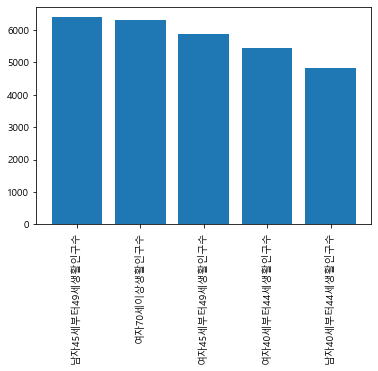

In [31]:
dong = 11650570
ppl_trend(dong, 13, 19)

반포제2동은 토요일 기준으로 13시부터 18시에 인구가 몰립니다.\
주 연령층은 40대로, 해당 시간을 미루어보아 반포한강공원에서 야외 활동을 나간 사람이 많을 것으로 추정됩니다. 해당 동은 작년 2분기 매출 데이터가 없어 주 매출 서비스 분야를 알기 어렵습니다. 


- 삼청동 ( 12시 ~ 17시 사이 생활인구 )

In [32]:
Image(url = 'https://github.com/swoos91/COVID19_EDA/blob/master/pt/%EC%82%BC%EC%B2%AD%EB%8F%99.png?raw=true')

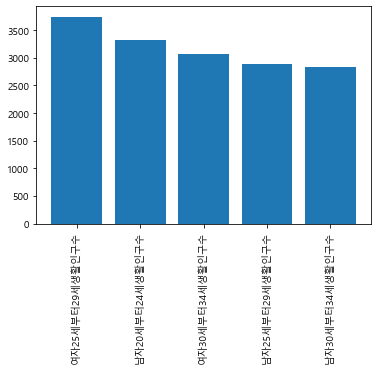

In [33]:
dong = 11110540
ppl_trend(11110540, 12, 18)

In [34]:
main_service_tmp = csm[csm['상권_코드'].isin(mkt[mkt['행정동코드']== dong ]['상권코드'].values)].copy()
main_service_ = main_service_tmp.sort_values('토요일_매출_비율', ascending=False).head(20)['서비스_업종_코드_명'].value_counts().index[:5].values
print(loc_code[loc_code['행정동코드_'] == dong]['행정동명_'].values[0], ' : ',main_service_)

서울특별시 종로구 삼청동  :  ['슈퍼마켓' '패션용품' '주방·가정용품' '의류점' '호프·간이주점']


삼청동은 토요일 기준으로 12시부터 17시에 인구가 몰립니다.\
주 연령층은 20~30대로, 작년 2분기 매출 데이터를 참고하면 ['슈퍼마켓' '패션용품' '주방·가정용품' '호프·간이주점' '의류점'] 관련 서비스를 주로 이용합니다.

- 신촌동( 13시 ~ 20시 사이 생활인구 )

In [35]:
Image(url = 'https://github.com/swoos91/COVID19_EDA/blob/master/pt/%EC%8B%A0%EC%B4%8C%EB%8F%99.png?raw=true')

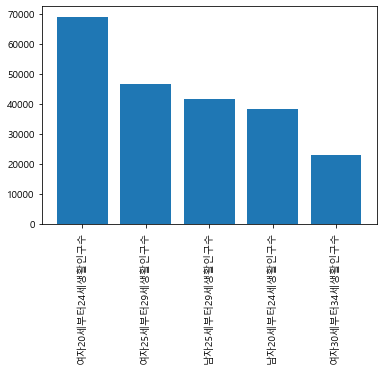

In [36]:
dong = 11410585
ppl_trend(dong, 13, 21)

In [37]:
main_service_tmp = csm[csm['상권_코드'].isin(mkt[mkt['행정동코드']== dong ]['상권코드'].values)].copy()
main_service_ = main_service_tmp.sort_values('토요일_매출_비율', ascending=False).head(20)['서비스_업종_코드_명'].value_counts().index[:5].values
print(loc_code[loc_code['행정동코드_'] == dong]['행정동명_'].values[0], ' : ',main_service_)

서울특별시 서대문구 신촌동  :  ['숙박업' '노래방' '두발미용업' '통신판매업' '호프·간이주점']


신촌동은 토요일 기준으로 13시부터 20시에 인구가 몰립니다.
주 연령층은 20~30대로, 작년 2분기 매출 데이터를 참고하면 ['노래방' '숙박업' '두발미용업' '식료품' '통신판매업'] 관련 서비스를 주로 이용합니다.

- 서교동( 15시 ~ 20시 사이 생활인구 )

In [38]:
Image(url = 'https://github.com/swoos91/COVID19_EDA/blob/master/pt/%EC%84%9C%EA%B5%90%EB%8F%99.png?raw=true')

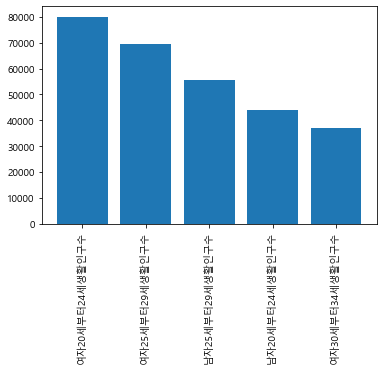

In [39]:
dong = 11440660
ppl_trend(dong, 15, 21)

In [40]:
main_service_tmp = csm[csm['상권_코드'].isin(mkt[mkt['행정동코드']== dong ]['상권코드'].values)].copy()
main_service_ = main_service_tmp.sort_values('토요일_매출_비율', ascending=False).head(20)['서비스_업종_코드_명'].value_counts().index[:5].values
print(loc_code[loc_code['행정동코드_'] == dong]['행정동명_'].values[0], ' : ',main_service_)

서울특별시 마포구 서교동  :  ['패션용품' '양식음식점' '패스트푸드점' '피부관리실' '외국어학원']


서교동은 토요일 기준으로 15시부터 20시에 인구가 몰립니다.
주 연령층은 20~30대로, 작년 2분기 매출 데이터를 참고하면 ['패션용품' '양식음식점' '피부관리실' '패스트푸드점' '외국어학원'] 관련 서비스를 주로 이용합니다.

### 3) 지난 토요일에 갑자기 생활인구가 급증한 지역

- 자양제4동( 15시 ~ 19시 사이 생활인구 )

In [41]:
Image(url = 'https://github.com/swoos91/COVID19_EDA/blob/master/pt/%EC%9E%90%EC%96%91%EC%A0%9C4%EB%8F%99.png?raw=true')

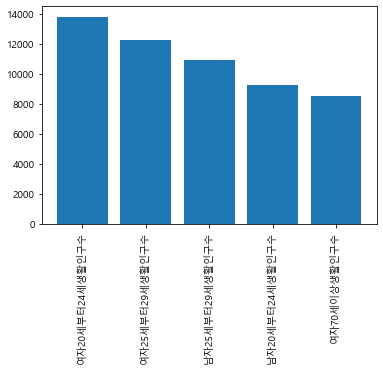

In [42]:
dong = 11215847
ppl_trend(11215847, 15, 20)

In [43]:
main_service_tmp = csm[csm['상권_코드'].isin(mkt[mkt['행정동코드']== dong ]['상권코드'].values)].copy()
main_service_ = main_service_tmp.sort_values('토요일_매출_비율', ascending=False).head(20)['서비스_업종_코드_명'].value_counts().index[:5].values
print(loc_code[loc_code['행정동코드_'] == dong]['행정동명_'].values[0], ' : ',main_service_)

서울특별시 광진구 자양제4동  :  ['오락·운동' '당구장' '호프·간이주점' '두발미용업' '네일숍']


자양제4동은 토요일 기준으로 15시부터 19시에 인구가 몰립니다.
주 연령층은 20대로, 작년 2분기 매출 데이터를 참고하면 ['오락·운동' '당구장' '네일숍' '두발미용업' '호프·간이주점'] 관련 서비스를 주로 이용합니다.

# 결론

4월 들어 사회적 거리두기가 점점 약화되는 경향성이 보이며,\
다른 연령대에 비해 20대의 움직임이 많은 것을 확인할 수 있습니다.